In [45]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import zarr
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import precision_recall_curve, auc
from IPython.display import display
import os
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")

In [40]:
splice_sites_df = pl.read_parquet("splice_sites.parquet")

clean_truth = dropped_truth.with_columns(
    pl.when(pl.col('type') == 'acceptor')
    .then(pl.lit('1').alias('is_acceptor').cast(pl.Int8))
    .otherwise(pl.lit('0').alias('is_acceptor').cast(pl.Int8)),
    pl.when(pl.col('type') == 'donor')
    .then(pl.lit('1').alias('is_donor').cast(pl.Int8))
    .otherwise(pl.lit('0').alias('is_donor').cast(pl.Int8))
).with_columns(
    pl.col('sequence').list.join('').alias('sequence')
)

for_sklearn = splice_sites_df.group_by('sequence').agg('prediction', 'truth').with_columns(
    pl.col('prediction').list.len().alias('prediction_count'),
).sort('prediction_count', descending=True).drop('prediction_count').head(20)

display(for_sklearn)

ColumnNotFoundError: truth

In [44]:
splice_sites_df = pl.read_parquet("splice_sites.parquet").with_columns(pl.col('sequence').list.join('').alias('sequence'), pl.col('seqname').alias('chrom')).select('chrom', 'index', 'strand', 'type','sequence')
print(splice_sites_df)

shape: (9_018, 5)
┌───────┬──────────┬────────┬──────────┬──────────┐
│ chrom ┆ index    ┆ strand ┆ type     ┆ sequence │
│ ---   ┆ ---      ┆ ---    ┆ ---      ┆ ---      │
│ str   ┆ i64      ┆ str    ┆ str      ┆ str      │
╞═══════╪══════════╪════════╪══════════╪══════════╡
│ chr1  ┆ 53945928 ┆ -      ┆ acceptor ┆ CG       │
│ chr1  ┆ 53939984 ┆ -      ┆ donor    ┆ GT       │
│ chr1  ┆ 53940096 ┆ -      ┆ acceptor ┆ AG       │
│ chr1  ┆ 53930038 ┆ -      ┆ donor    ┆ GT       │
│ chr1  ┆ 53930144 ┆ -      ┆ acceptor ┆ AG       │
│ …     ┆ …        ┆ …      ┆ …        ┆ …        │
│ chr9  ┆ 69053139 ┆ +      ┆ acceptor ┆ AG       │
│ chr9  ┆ 69053259 ┆ +      ┆ donor    ┆ GT       │
│ chr9  ┆ 69064937 ┆ +      ┆ acceptor ┆ AG       │
│ chr9  ┆ 69065034 ┆ +      ┆ donor    ┆ GT       │
│ chr9  ┆ 69072611 ┆ +      ┆ acceptor ┆ AG       │
└───────┴──────────┴────────┴──────────┴──────────┘


In [43]:
zarr_root = zarr.group(store=zarr.DirectoryStore("results/spliceai_predictions.zarr"))
acceptor_predictions = zarr_root.require_group('acceptor_predictions')
donor_predictions = zarr_root.require_group('donor_predictions')
acceptor_truth = zarr_root.require_group('acceptor_truth')
donor_truth = zarr_root.require_group('donor_truth')


ACCEPTOR Results:
Sequence AUPRC      Count     
------------------------------
AG       0.9292     4143      
GC       0.4330     42        
GA       0.3857     19        
TT       0.3510     26        
TC       0.3487     32        
CC       0.3400     52        
GG       0.2922     34        
CT       0.2819     29        
GT       0.2727     20        
CG       0.2688     29        

DONOR Results:
Sequence AUPRC      Count     
------------------------------
GT       0.9312     4138      
GC       0.7103     44        
CC       0.5247     20        
CT       0.4691     47        
TG       0.4689     40        
GG       0.4383     20        
GA       0.4210     17        
TT       0.4090     63        
TC       0.3589     24        
CA       0.3328     23        
{'acceptor': {'AG': {'precision': array([7.20395848e-04, 7.20395883e-04, 7.20395918e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), 'recall': array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,


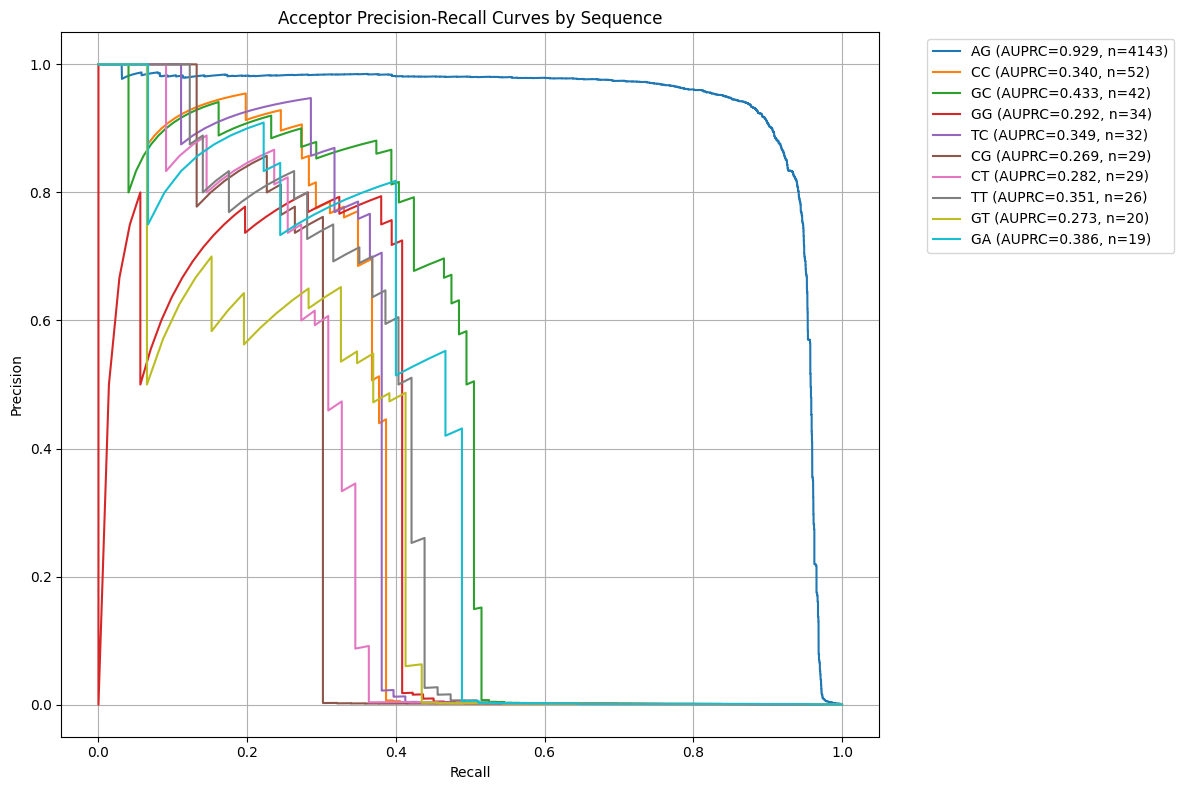

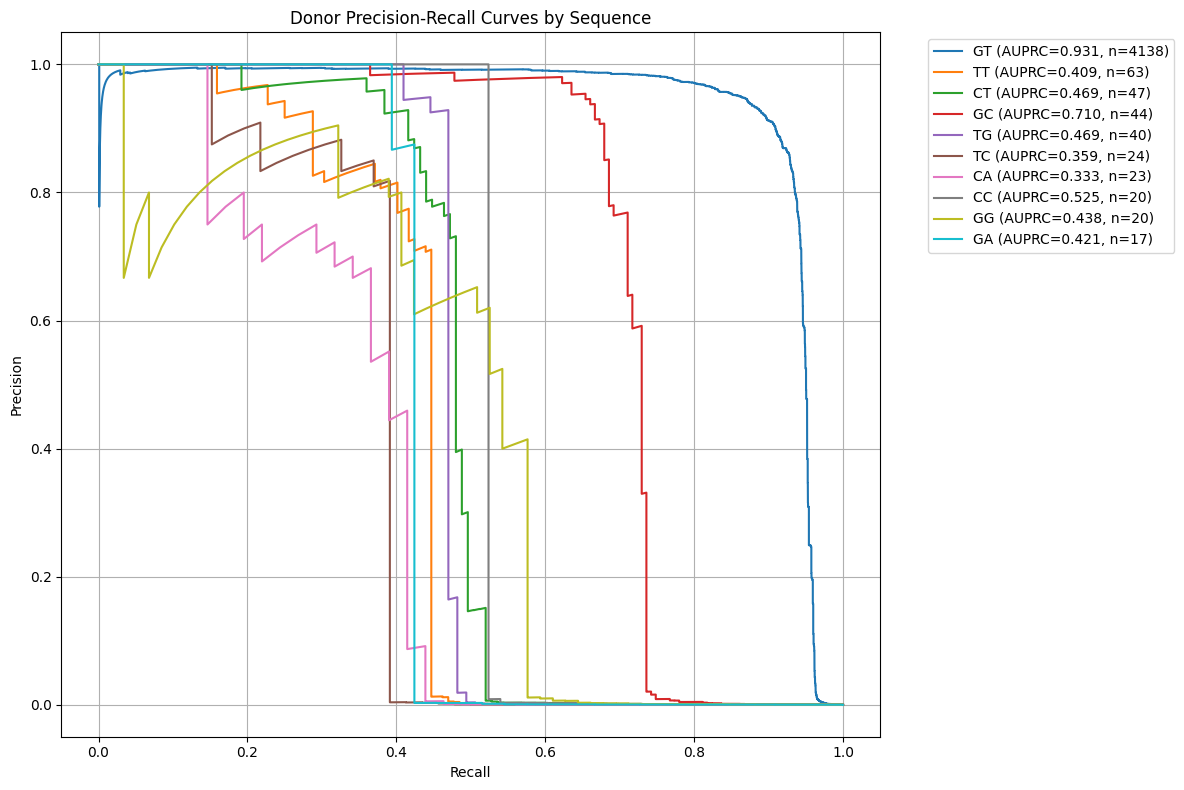

In [ ]:
args = [(acceptor_predictions, acceptor_truth, "acceptor"), 
        (donor_predictions, donor_truth, "donor")]

results = {}

df = splice_sites_df

for pred_dataset, truth_dataset, site_type in args:    
    type_df = df.filter(pl.col('type') == site_type)
    
    sequence_counts = Counter(type_df['sequence'])
    top_sequences = [seq for seq, _ in sequence_counts.most_common(10)]
    
    results[site_type] = {}
    
    for sequence in top_sequences:
        seq_df = type_df.filter(pl.col('sequence') == sequence)
        
        window_size = 5000
        total_sites = len(seq_df)
        total_size = total_sites * window_size
        
        ground_truth = np.zeros(total_size, dtype=np.int8)
        predictions = np.zeros(total_size, dtype=np.float64)
        
        current_idx = 0
        for site in seq_df.iter_rows(named=True):
            index = site['index']
            chrom = site['chrom']
            
            half_window = window_size // 2
            window_start = index - half_window
            window_end = window_start + window_size
            
            site_prediction = pred_dataset[chrom][window_start:window_end]
            site_truth = truth_dataset[chrom][window_start:window_end]
            
            predictions[current_idx:current_idx+window_size] = site_prediction
            ground_truth[current_idx:current_idx+window_size] = site_truth
            current_idx += window_size
        
        precision, recall, _ = precision_recall_curve(ground_truth, predictions)
        auprc = auc(recall, precision)
        
        k = int(np.sum(ground_truth))
        if k > 0:
            top_k_indices = np.argsort(predictions)[-k:]
            top_k_accuracy = np.sum(ground_truth[top_k_indices]) / k
        else:
            top_k_accuracy = 0.0
        
        results[site_type][sequence] = {
            'precision': precision,
            'recall': recall,
            'auprc': auprc,
            'topk': top_k_accuracy,
            'count': total_sites
        }


plt.figure(figsize=(12, 8))
for sequence, data in results['acceptor'].items():
    plt.plot(data['recall'], data['precision'], 
            label=f'{sequence} (AUPRC={data["auprc"]:.3f}, n={data["count"]}, topk={data["topk"]:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Acceptor Precision-Recall Curves by Sequence')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('auprc_acceptor_by_sequence.svg', dpi=300, format='svg')


plt.figure(figsize=(12, 8))
for sequence, data in results['donor'].items():
    plt.plot(data['recall'], data['precision'], 
            label=f'{sequence} (AUPRC={data["auprc"]:.3f}, n={data["count"]}), topk={data["topk"]:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Donor Precision-Recall Curves by Sequence')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('auprc_donor_by_sequence.svg', dpi=300, format='svg')

for site_type in ['acceptor', 'donor']:
    print(f"\n{site_type.upper()} Results:")
    sequence_results = [(seq, data['auprc'], data['count']) for seq, data in results[site_type].items()]
    sequence_results.sort(key=lambda x: x[1], reverse=True) # Sort by AUPRC
    
    print(f"{'Sequence':<8} {'AUPRC':<10} {'Count':<10}")
    print("-" * 30)
    for seq, auprc, count in sequence_results:
        print(f"{seq:<8} {auprc:<10.4f} {count:<10}")

print(results)